In [1]:
import pandas as pd
import datetime as dt
import matplotlib.pyplot as plt 
import seaborn as sns
from wordcloud import WordCloud, STOPWORDS 
import nltk
from nltk.corpus import stopwords 
from nltk.tokenize import word_tokenize 
import numpy as np
import scipy as sp
import heapq
from tqdm import tqdm_notebook as tqdm

from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LassoCV

from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.utils import resample
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegressionCV
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import scale
from sklearn.metrics import roc_auc_score,accuracy_score
from sklearn.model_selection import GridSearchCV
from random import randint 
from sklearn.decomposition import PCA
from sklearn import metrics

from sklearn import tree
from sklearn.utils import shuffle

In [2]:
df = pd.read_csv("reddit_test_posts.csv")

In [18]:
#filter for 2018 posts only
df_18 = df.loc[df['election year']==2018]

In [33]:
df_18['subreddit'].value_counts()

politics             42954
Economics             1295
arizonapolitics        148
wisconsinpolitics       74
Name: subreddit, dtype: int64

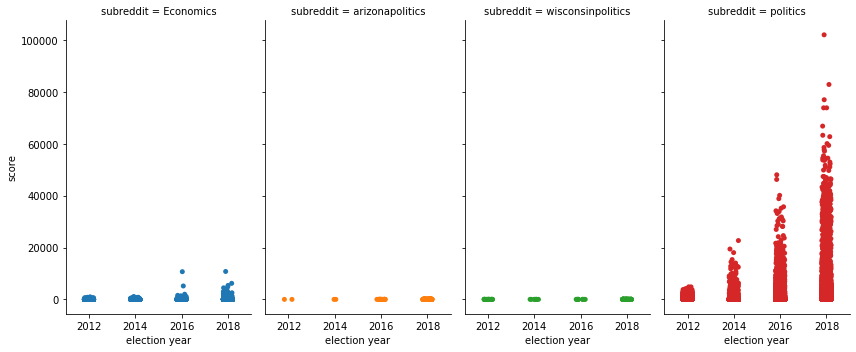

In [3]:
sns.catplot(x="election year", y="score", hue="subreddit",
            col="subreddit", aspect=.6,
             data=df);


In [5]:
nltk.download('punkt')

[nltk_data] Downloading package punkt to
[nltk_data]     /Users/ericenglin/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [6]:
def stringinize(df):
    comment_words = ' '
    token_list = []
    
    for x in df['title']:

        # typecaste each val to string      
        val = str(x.strip()) 

        # split the value 
        #tokens = val.split() 
        
        #tokenize
        tokens = word_tokenize(x)
        
        # Converts each token into lowercase 
        for i in range(len(tokens)): 
            tokens[i] = tokens[i].lower() 

        for words in tokens: 
            comment_words = comment_words + words + " "
            token_list.append(words)
    
    return comment_words, token_list

In [7]:
stopwords = set(STOPWORDS)

for x in ['-','|','--', '$', '%', '.', ',','?',':',';',"'", '"', "'s", 's', '&', '[',']',"'m",
            '...', '(',')','!', '``','‘',"n't","’", "'"," ``","''", "”", '“','t', "'ve'"]:
    stopwords.add(x)

In [8]:
subreddits = ['Economics','wisconsinpolitics',
             'arizonapolitics','politics']

In [19]:
# make NLTK dataset for dictionaries with words for each subreddit

word_dict = { "subreddit":[], 
                "comment_words":[], 
                "token_list":[]}

for x in subreddits:
    df_temp = df_18.loc[df_18['subreddit']==x]
    
    
    word_dict["subreddit"].append(str(x))
    
    comment_words, token_list = stringinize(df_temp)
    word_dict["comment_words"].append(comment_words)
    word_dict["token_list"].append(token_list)

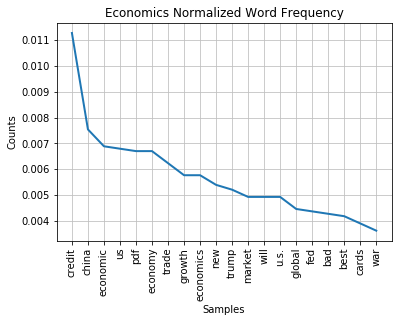

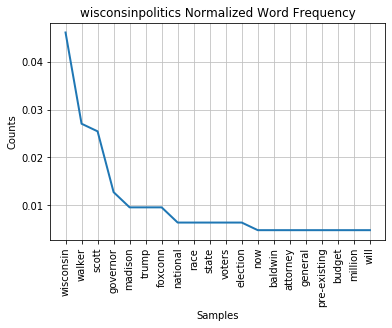

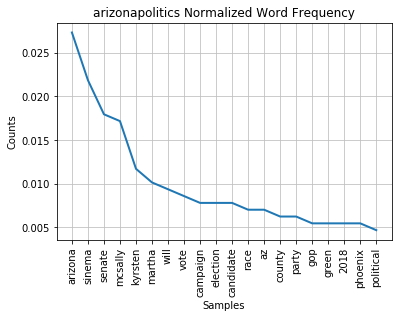

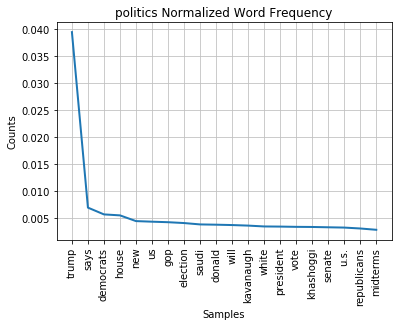

In [20]:
class_list = []
freq_list = []
word_list = []
z=0

for x, y in zip(word_dict['token_list'], subreddits):    
    filtered_sentence = [] 

    for w in x: 
        if w not in stopwords: 
            filtered_sentence.append(w) 


    fd = nltk.FreqDist(filtered_sentence)
    total = fd.N()
    for word in fd:
        fd[word] /= float(total)
    
    fd.plot(20,cumulative=False,title = str(y)+" Normalized Word Frequency")
    
    for word in fd:
        word_list.append(word)
        freq_list.append(fd[word])
        class_list.append(y)

# Function to generate frame of posts as rows and words as columns

In [106]:
df_new = pd.DataFrame(df_18['title'])

In [107]:
df_new.head()

,title
0,Saudi Arabia Tells US President Donald Trump N...
1,The 10-year average 10 years out
2,Ronaldinho and the Right-Winger. Brazilian foo...
3,BIS’s latest hunt for Zombie (firms)
4,From convergence to divergence: Portuguese eco...


In [108]:
def get_tokens(df):
    tokens_clean = []
    for post in tqdm(range(len(df))):
        x = df['title'][post]
        # typecaste each val to string and strip     
        val = str(x.strip())       
        #tokenize
        tokens = word_tokenize(val)
        for word in tokens:
            word = word.lower()
            if word not in stopwords:
                tokens_clean.append(word)
        
    fd = nltk.FreqDist(tokens_clean)
    return fd


In [109]:
wordfreq = get_tokens(df_new)
most_freq = heapq.nlargest(200, wordfreq, key=wordfreq.get)

In [120]:
import heapq
most_freq = heapq.nlargest(50000, wordfreq, key=wordfreq.get)

In [121]:
def get_matrix(df,most_freq):    #some code from https://stackabuse.com/python-for-nlp-creating-bag-of-words-model-from-scratch/
    post_vectors = []
    for post in tqdm(range(len(df))):
        x = df['title'][post]
        val = str(x.strip())  
        post_tokens = nltk.word_tokenize(val)
        post_vec = []
        for token in most_freq:
            if token in post_tokens:
                post_vec.append(1)
            else:
                post_vec.append(0)
        post_vectors.append(post_vec)
        
    return post_vectors

In [122]:
post_matrix = get_matrix(df_new,most_freq)

In [123]:
post_matrix = np.asarray(post_matrix)
df_post = pd.DataFrame(post_matrix, columns = most_freq)
df_post['subreddit_class']=df_18['subreddit']
#df_post.to_csv("post_matrix.csv", index=False)


In [124]:
preds = pd.read_csv("X_test_smaller.csv")

In [125]:
col_names = preds.columns

In [129]:
n=0
col_nums = []
bad_col_names = []
for x in col_names:
    if x in df_post.columns:
        n+=1
        y = str(x)
        col_nums.append(df_post.columns.get_loc(x))
    else:
        bad_col_names.append(x)

df_final = df_post.iloc[:,col_nums]
df_final['subreddit_class'] = df_post['subreddit_class']

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  del sys.path[0]


In [131]:
print(len(col_nums))
print(len(col_names))
print(len(bad_col_names))

1265
1308
43


In [134]:
for x in bad_col_names:
    df_final[x]=0

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [135]:
df_final.head()

,dead,student,girl,probe,48,ll,thinks,asks,45,allegations,...,optimal,mammograms,85.6,invaded,viewpoints,smug,selection,lib,uterus,viewpoint
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [137]:
df_final.describe()

,dead,student,girl,probe,48,ll,thinks,asks,45,allegations,...,optimal,mammograms,85.6,invaded,viewpoints,smug,selection,lib,uterus,viewpoint
count,44471.000000,44471.000000,44471.000000,44471.000000,44471.000000,44471.000000,44471.000000,44471.000000,44471.000000,44471.000000,...,44471.0,44471.0,44471.0,44471.0,44471.0,44471.0,44471.0,44471.0,44471.0,44471.0
mean,0.002563,0.001349,0.000315,0.006499,0.000337,0.001754,0.001102,0.001484,0.000315,0.001597,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
std,0.050566,0.036707,0.017740,0.080353,0.018363,0.041844,0.033176,0.038496,0.017740,0.039925,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
75%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [139]:
df_final['subreddit_class'].value_counts()

politics             42954
Economics             1295
arizonapolitics        148
wisconsinpolitics       74
Name: subreddit_class, dtype: int64

In [140]:
politics = df_final.loc[df_final['subreddit_class']=='politics']
Economics = df_final.loc[df_final['subreddit_class']=='Economics']
arizonapolitics = df_final.loc[df_final['subreddit_class']=='arizonapolitics']
wisconsinpolitics = df_final.loc[df_final['subreddit_class']=='wisconsinpolitics']


In [144]:
politics_one = politics[:20000]
politics_two = politics[20000:]


In [145]:
politics_one.to_csv("politics_one.csv")
politics_two.to_csv("politics_two.csv")
Economics.to_csv("Economics.csv")
arizonapolitics.to_csv("arizonapolitics.csv")
wisconsinpolitics.to_csv("wisconsinpolitics.csv")


